In [1]:
import torch
from torchvision import datasets, transforms


def load_data():
    """loads MNIST datasets with 'RTS' (rotation, translation, scale)
    transformation

    Returns:
        train_dataset (torch dataset): training dataset
        test_dataset (torch dataset): test dataset
    """
    def place_digit_randomly(img):
        new_img = torch.zeros([42, 42])
        x_pos, y_pos = torch.randint(0, 42-28, (2,))
        new_img[y_pos:y_pos+28, x_pos:x_pos+28] = img
        return new_img
        
    transform = transforms.Compose([
        transforms.RandomAffine(degrees=(-45, 45), 
                                scale=(0.7, 1.2)),
        transforms.ToTensor(),
        transforms.Lambda(lambda img: place_digit_randomly(img)),
        transforms.Lambda(lambda img: img.unsqueeze(0))
    ])
    train_dataset = datasets.MNIST('./data', transform=transform, 
                                   train=True, download=True)
    test_dataset = datasets.MNIST('./data', transform=transform, 
                                   train=True, download=True)
    return train_dataset, test_dataset


train_dataset, test_dataset = load_data()

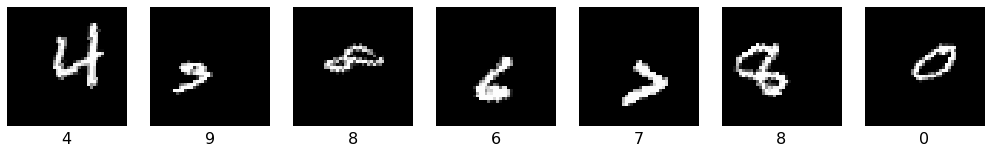

In [2]:
import matplotlib.pyplot as plt
import numpy as np

train_dataset, test_dataset = load_data()

n_samples = 7
fig = plt.figure(figsize=(n_samples*2.5, 2.5))
i_samples = np.random.choice(range(len(train_dataset)), 
                             n_samples, replace=False)
for counter, i_sample in enumerate(i_samples):
    img, label = train_dataset[i_sample]
    
    plt.subplot(1, n_samples, counter + 1)
    plt.imshow(transforms.ToPILImage()(img), cmap='gray')
    plt.axis('off')
    plt.title(str(label), fontsize=16, y=-0.2)

In [3]:
import torch.nn as nn
import numpy as np
import torch.nn.functional as F


def get_number_of_trainable_parameters(model):
    """taken from
    discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325
    """
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params


class CNN(nn.Module):
    
    def __init__(self, img_size=42, include_ST=False):
        super(CNN, self).__init__()
        self.ST = include_ST
        self.name = 'ST-CNN Affine' if include_ST else 'CNN'
        c_dim = 32 if include_ST else 36
        self.convs = nn.Sequential(
            nn.Conv2d(1, c_dim, kernel_size=9, stride=1, padding=0),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(True),
            nn.Conv2d(c_dim, c_dim, kernel_size=7, stride=1, padding=0),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(True),
        )
        out_conv = int((int((img_size - 8)/2) - 6)/2)
        self.classification = nn.Sequential(
            nn.Linear(out_conv**2*c_dim, 50),
            nn.ReLU(True),
            nn.Linear(50, 10),
            nn.LogSoftmax(dim=1),            
        )
        if include_ST:
            loc_conv_out_dim = int((int(img_size/2) - 4)/2) - 4
            loc_regression_layer = nn.Linear(20, 6)
            # initalize final regression layer to identity transform
            loc_regression_layer.weight.data.fill_(0)
            loc_regression_layer.bias = nn.Parameter(
                torch.tensor([1., 0., 0., 0., 1., 0.]))
            self.localisation_net = nn.Sequential(
                nn.Conv2d(1, 20, kernel_size=5, stride=1, padding=0),
                nn.MaxPool2d(kernel_size=(2,2), stride=2),
                nn.ReLU(True),
                nn.Conv2d(20, 20, kernel_size=5, stride=1, padding=0),
                nn.ReLU(True),
                nn.Flatten(),
                nn.Linear(loc_conv_out_dim**2*20, 20),
                nn.ReLU(True),
                loc_regression_layer
            ) 
        return
    
    def forward(self, img):
        batch_size = img.shape[0]
        if self.ST:
            out_ST = self.ST_module(img)
            img = out_ST
        out_conv = self.convs(img)
        out_classification = self.classification(out_conv.view(batch_size, -1))
        return out_classification
      
    def ST_module(self, inp):
        # act on twice downsampled inp
        down_inp = F.interpolate(inp, scale_factor=0.5, mode='bilinear',
                                 recompute_scale_factor=False, align_corners=False)
        theta_vector = self.localisation_net(down_inp)
        # affine transformation
        theta_matrix = theta_vector.view(-1, 2, 3)
        # grid generator
        grid = F.affine_grid(theta_matrix, inp.size(), align_corners=False)
        # sampler
        out = F.grid_sample(inp, grid, align_corners=False)
        return out
    
    def get_attention_rectangle(self, inp):
        assert inp.shape[0] == 1, 'batch size has to be one'
        # act on twice downsampled inp
        down_inp = F.interpolate(inp, scale_factor=0.5, mode='bilinear',
                                 recompute_scale_factor=False, align_corners=False)
        theta_vector = self.localisation_net(down_inp)
        # affine transformation matrix
        theta_matrix = theta_vector.view(2, 3).detach()
        # create normalized target rectangle input image
        target_rectangle = torch.tensor([
            [-1., -1., 1., 1., -1], 
            [-1., 1., 1., -1, -1.], 
            [1, 1, 1, 1, 1]]
        ).to(inp.device)
        # get source rectangle by transformation
        source_rectangle = torch.matmul(theta_matrix, target_rectangle)        
        return source_rectangle
    
    
# instantiate models
cnn = CNN(img_size=42, include_ST=False)
st_cnn = CNN(img_size=42, include_ST=True)
# print trainable parameters
for model in [cnn, st_cnn]:
    num_trainable_params = get_number_of_trainable_parameters(model)
    print(f'{model.name} has {num_trainable_params} trainable parameters')

CNN has 112052 trainable parameters
ST-CNN Affine has 110478 trainable parameters


In [4]:
from livelossplot import PlotLosses
from torch.utils.data import DataLoader


def train(model, dataset):
    # fix hyperparameters
    epochs = 50
    learning_rate = 0.01
    batch_size = 256
    step_size_scheduler = 50000
    gamma_scheduler = 0.1
    # set device    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f'Device: {device}')
    
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True,
                             num_workers=4)
    
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=gamma_scheduler,
                                                step_size=step_size_scheduler)
    
    losses_plot = PlotLosses()
    print(f'Start training with {model.name}')
    for epoch in range(1, epochs+1):
        avg_loss = 0
        for data, label in data_loader:
            model.zero_grad()
            
            log_prop_pred = model(data.to(device))
            # multinomial cross entropy loss
            loss = F.nll_loss(log_prop_pred, label.to(device))
            
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            avg_loss += loss.item() / len(data_loader)
        
        losses_plot.update({'log loss': np.log(avg_loss)})
        losses_plot.send()
    trained_model = model
    return trained_model

In [5]:
def test(trained_model, test_dataset):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True,
                            num_workers=4)
    with torch.no_grad():
        trained_model.eval()
        test_loss = 0
        correct = 0
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)

            log_prop_pred = trained_model(data)
            class_pred = log_prop_pred.max(1, keepdim=True)[1]

            test_loss += F.nll_loss(log_prop_pred, label).item()/len(test_loader)
            correct += class_pred.eq(label.view_as(class_pred)).sum().item()

        print(f'{trained_model.name}: avg loss: {np.round(test_loss, 2)},  ' +
              f'avg acc {np.round(100*correct/len(test_dataset), 2)}%')
    return

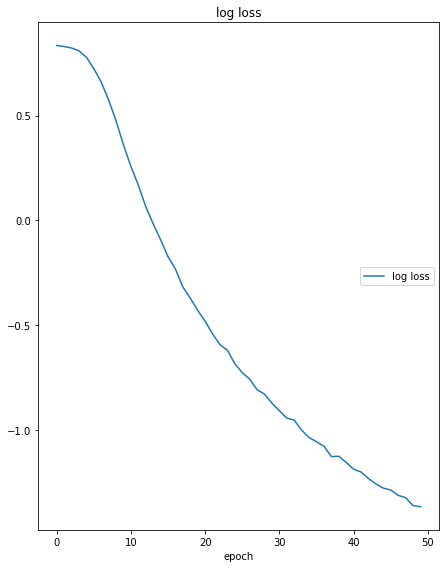

log loss
	log loss         	 (min:   -1.366, max:    0.834, cur:   -1.366)


In [6]:
trained_cnn = train(cnn, train_dataset)

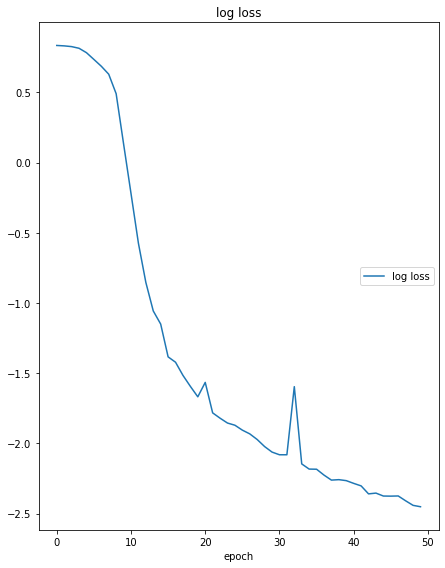

log loss
	log loss         	 (min:   -2.451, max:    0.834, cur:   -2.451)


In [7]:
trained_st_cnn = train(st_cnn, train_dataset)

In [8]:
for trained_model in [trained_cnn, trained_st_cnn]:
    test(trained_model, test_dataset)

CNN: avg loss: 0.27,  avg acc 91.76%
ST-CNN Affine: avg loss: 0.09,  avg acc 97.22%


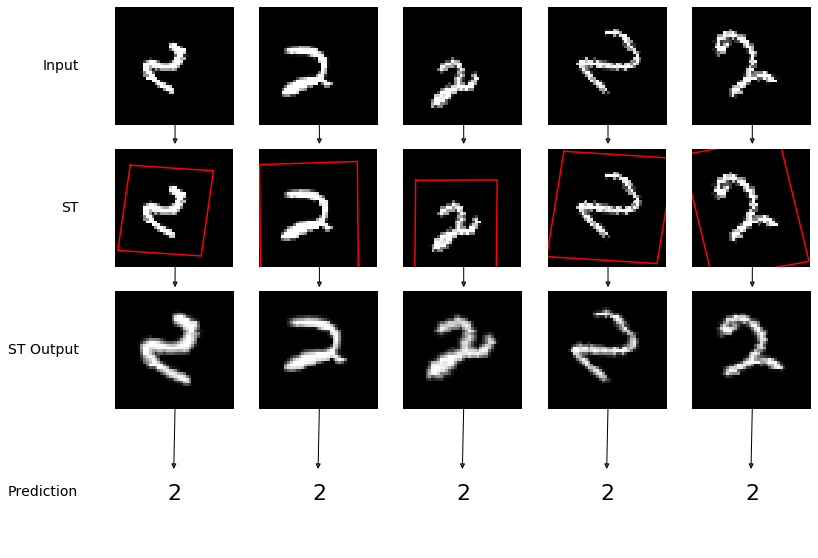

In [9]:
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch


def visualize_learned_transformations(trained_st_cnn, test_dataset, digit_class=8):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    trained_st_cnn.to(device)
    n_samples = 5
    
    data_loader = DataLoader(test_dataset, batch_size=256, shuffle=True)
    batch_img, batch_label = next(iter(data_loader))
    i_samples = np.where(batch_label.numpy() == digit_class)[0][0:n_samples]
    
    fig = plt.figure(figsize=(n_samples*2.5, 2.5*4))
    for counter, i_sample in enumerate(i_samples):
        img = batch_img[i_sample]
        label = batch_label[i_sample]
        
        # input image
        ax1 = plt.subplot(4, n_samples, 1 + counter)
        plt.imshow(transforms.ToPILImage()(img), cmap='gray')
        plt.axis('off')
        if counter == 0:
            ax1.annotate('Input', xy=(-0.3, 0.5), xycoords='axes fraction',
                         fontsize=14, va='center', ha='right')
        
        # image including border of affine transformation
        img_inp = img.unsqueeze(0).to(device)
        source_normalized = trained_st_cnn.get_attention_rectangle(img_inp)
        # remap into absolute values
        source_absolute = 0 + 20.5*(source_normalized.cpu() + 1)
        ax2 = plt.subplot(4, n_samples, 1 + counter + n_samples)
        x = np.arange(42)
        y = np.arange(42)
        X, Y = np.meshgrid(x, y)
        plt.pcolor(X, Y, img.squeeze(0), cmap='gray')
        plt.plot(source_absolute[0], source_absolute[1], color='red')
        plt.axis('off')
        ax2.axes.set_aspect('equal')
        ax2.set_ylim(41, 0)
        ax2.set_xlim(0, 41)
        if counter == 0:
            ax2.annotate('ST', xy=(-0.3, 0.5), xycoords='axes fraction',
                         fontsize=14, va='center', ha='right')
        # add arrow between
        con = ConnectionPatch(xyA=(21, 41), xyB=(21, 0), coordsA='data', 
                              coordsB='data', axesA=ax1, axesB=ax2, 
                              arrowstyle="-|>", shrinkB=5)
        ax2.add_artist(con)
        
        # ST module output
        st_img = trained_st_cnn.ST_module(img.unsqueeze(0).to(device))
        
        ax3 = plt.subplot(4, n_samples, 1 + counter + 2*n_samples)
        plt.imshow(transforms.ToPILImage()(st_img.squeeze(0).cpu()), cmap='gray')
        plt.axis('off')
        if counter == 0:
            ax3.annotate('ST Output', xy=(-0.3, 0.5), xycoords='axes fraction',
                         fontsize=14, va='center', ha='right')
        # add arrow between
        con = ConnectionPatch(xyA=(21, 41), xyB=(21, 0), coordsA='data', 
                              coordsB='data', axesA=ax2, axesB=ax3,
                              arrowstyle="-|>", shrinkB=5)
        ax3.add_artist(con)
        
        # predicted label
        log_pred = trained_st_cnn(img.unsqueeze(0).to(device))
        pred_label = log_pred.max(1)[1].item()
        
        ax4 = plt.subplot(4, n_samples, 1 + counter + 3*n_samples)
        plt.text(0.45, 0.43, str(pred_label), fontsize=22)
        plt.axis('off')
        #plt.title(f'Ground Truth {label.item()}', y=-0.1, fontsize=14)
        if counter == 0:
            ax4.annotate('Prediction', xy=(-0.3, 0.5), xycoords='axes fraction',
                         fontsize=14, va='center', ha='right')
        # add arrow between
        con = ConnectionPatch(xyA=(21, 41), xyB=(0.5, 0.65), coordsA='data', 
                              coordsB='data', axesA=ax3, axesB=ax4, 
                              arrowstyle="-|>", shrinkB=5)
        ax4.add_artist(con)
    return
            
        
visualize_learned_transformations(st_cnn, test_dataset, 2)